In [12]:
#!conda install pytorch
#!conda install Pillow
#!conda install scikit-image
#conda install -c conda-forge opencv
#conda install -c conda-forge keras
#conda install -c conda-forge tensorflow

In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder
import cv2
import PIL


Setting up GPU for caluculations

In [ ]:
#conda create --name tf_gpu tensorflow-gpu 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
pysical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(pysical_devices))
tf.config.experimental.set_memory_growth(pysical_devices[0], True)

Num GPUs Available:  1


Converting the JSON file to a Pandas dataframe but dropping image 4215425.jpg as this was corrupted

Setting up the paths to the files. 

In [3]:
train_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\train_2'
test_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\test_2'
valid_path = r'C:\Users\Gebruiker\Documents\DataScience\ADA\Project\Food\images\valid_2'

Changing the images so Inception V3 can read them 

In [4]:
train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=train_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10)
test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)
valid_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path,target_size=(299,299),classes=['On a budget','Moderate spend','Special occasion','Spare no expense'],batch_size=10,shuffle=False)


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


How Inception V3 sees images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

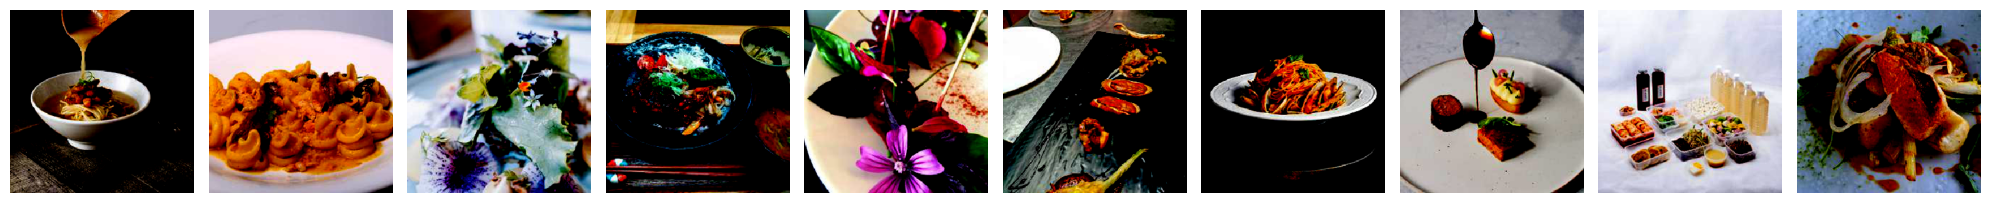

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [5]:
imgs, labels = next(train_batch)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

## InceptionV3 model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


#Set up values
epochs = 10
input_shape=(299,299,3)

# Load the InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the InceptionV3 layers
for layer in inceptionv3.layers:
    layer.trainable = False

# Build a classifier on top of the InceptionV3 model with additional layers
model = Sequential([
    inceptionv3,
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu'),
    GlobalAveragePooling2D(),

    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=8, activation='relu'),
    Dense(units=4, activation='softmax')
])


# Compile the model
#optimizer = Adam(learning_rate=0.005)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_batch = train_datagen.flow_from_directory(train_path,
                                                target_size=(299, 299),
                                                batch_size=16,
                                                class_mode='categorical')
test_batch = test_datagen.flow_from_directory(test_path,
                                              target_size=(299, 299),
                                              batch_size=16,
                                              class_mode='categorical')
valid_batch = valid_datagen.flow_from_directory(valid_path,
                                                 target_size=(299, 299),
                                                 batch_size=16,
                                                 class_mode='categorical')

# Train the model and save the history
history = model.fit(train_batch, epochs=epochs, validation_data=test_batch)



# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valid_batch)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')


Found 17727 images belonging to 4 classes.
Found 3623 images belonging to 4 classes.
Found 602 images belonging to 4 classes.
Epoch 1/10
1108/1108 [==============================] - 301s 260ms/step - loss: 1.2751 - accuracy: 0.3804 - val_loss: 1.3022 - val_accuracy: 0.3583
Epoch 2/10
1108/1108 [==============================] - 274s 247ms/step - loss: 1.2241 - accuracy: 0.4183 - val_loss: 1.3330 - val_accuracy: 0.3701
Epoch 3/10
1108/1108 [==============================] - 273s 246ms/step - loss: 1.2027 - accuracy: 0.4310 - val_loss: 1.2965 - val_accuracy: 0.3577
Epoch 4/10
1108/1108 [==============================] - 272s 246ms/step - loss: 1.1911 - accuracy: 0.4432 - val_loss: 1.2911 - val_accuracy: 0.3768
Epoch 5/10
1108/1108 [==============================] - 272s 245ms/step - loss: 1.1761 - accuracy: 0.4497 - val_loss: 1.3090 - val_accuracy: 0.3707
Epoch 6/10
1108/1108 [==============================] - 272s 246ms/step - loss: 1.1570 - accuracy: 0.4647 - val_loss: 1.3833 - val_acc

Graphical plot of loss and accuracy in training and test set 

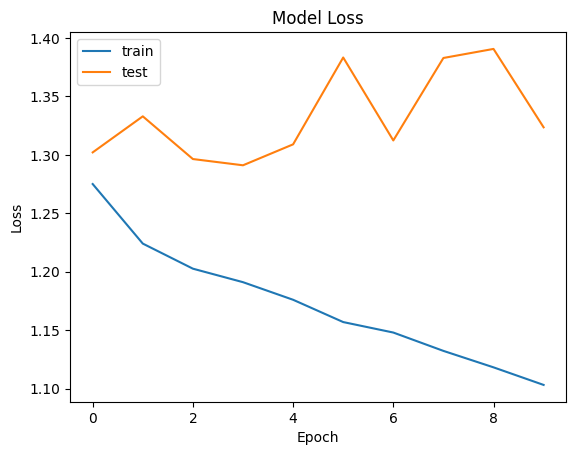

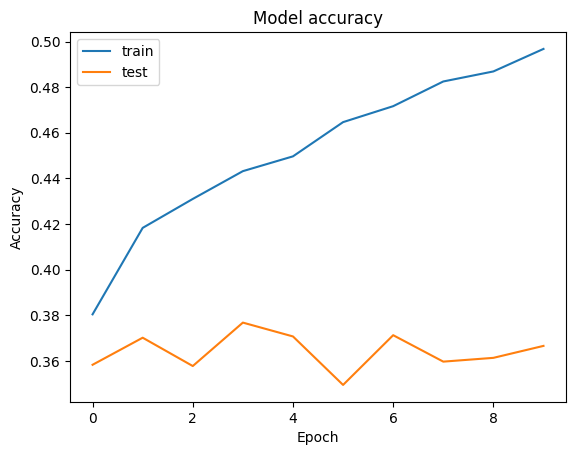

In [8]:
# Plot the loss and validation loss over epochs
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Exporting the model. 

In [10]:
# Save Weight model
model.save_weights("model1.h5")